# Evaluation of PTQ on CRDNN

## Base model

In [ ]:
from speechbrain.pretrained import EncoderDecoderASR

In [2]:
asr_model = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_models/speechbrain/asr-crdnn-rnnlm-librispeech", run_opts={"device":"cuda"})

In [3]:
import torch

dummy_input = torch.rand(1, 580, 40).cuda()

In [ ]:
torch.onnx.export(asr_model.mods.encoder.model,
             args=dummy_input,
             f="asr-crdnn-encoder_librispeech.onnx",
             export_params=True,
             opset_version=11,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

## Post training quantization

In [5]:
import sys
import torch
import logging
import speechbrain as sb
from speechbrain.utils.distributed import run_on_main, if_main_process
from hyperpyyaml import load_hyperpyyaml
from pathlib import Path

import torch
import torch.utils.data
from speechbrain.dataio.dataloader import SaveableDataLoader
from speechbrain.dataio.dataloader import LoopedLoader
from torch import nn
import torch.nn.functional as F

from pytorch_quantization import nn as quant_nn
from pytorch_quantization import calib
from pytorch_quantization import tensor_quant
from pytorch_quantization.tensor_quant import QuantDescriptor

from tqdm import tqdm

logger = logging.getLogger(__name__)

import soundfile as sf
import resampy
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters_dev(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    trimmed_string = batch["text"].strip()
    words = trimmed_string.split()
    new_text = ' '.join(words[1:])
    batch["text"] = new_text
    batch["input_values"] = flac_to_array_with_sampling_rate(dev_clean_dict[words[0]]['file_path'])
    return batch

def flac_to_array_with_sampling_rate(file_path, target_sr=16000):
    data, sr = sf.read(file_path, dtype='float32')

    if sr != target_sr:
        data = resampy.resample(data, sr, target_sr)

    return data


# Define training procedure
class ASR(sb.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the waveform batches to the output probabilities."""
        batch = batch.to(self.device)
        wavs, wav_lens = batch.sig
        tokens_bos, _ = batch.tokens_bos
        wavs, wav_lens = wavs.to(self.device), wav_lens.to(self.device)

        # Add augmentation if specified
        if stage == sb.Stage.TRAIN:
            if hasattr(self.modules, "env_corrupt"):
                wavs_noise = self.modules.env_corrupt(wavs, wav_lens)
                wavs = torch.cat([wavs, wavs_noise], dim=0)
                wav_lens = torch.cat([wav_lens, wav_lens])
                tokens_bos = torch.cat([tokens_bos, tokens_bos], dim=0)

            if hasattr(self.hparams, "augmentation"):
                wavs = self.hparams.augmentation(wavs, wav_lens)

        # Forward pass
        feats = self.hparams.compute_features(wavs)
        feats = self.modules.normalize(feats, wav_lens)
        x = self.modules.enc(feats.detach())
        e_in = self.modules.emb(tokens_bos)  # y_in bos + tokens
        h, _ = self.modules.dec(e_in, x, wav_lens)

        # Output layer for seq2seq log-probabilities
        logits = self.modules.seq_lin(h)
        p_seq = self.hparams.log_softmax(logits)

        # Compute outputs
        if stage == sb.Stage.TRAIN:
            current_epoch = self.hparams.epoch_counter.current
            if current_epoch <= self.hparams.number_of_ctc_epochs:
                # Output layer for ctc log-probabilities
                logits = self.modules.ctc_lin(x)
                p_ctc = self.hparams.log_softmax(logits)
                return p_ctc, p_seq, wav_lens
            else:
                return p_seq, wav_lens
        else:
            if stage == sb.Stage.VALID:
                p_tokens, scores = self.hparams.valid_search(x, wav_lens)
            else:
                p_tokens, scores = self.hparams.test_search(x, wav_lens)
            return p_seq, wav_lens, p_tokens

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss (CTC+NLL) given predictions and targets."""

        current_epoch = self.hparams.epoch_counter.current
        if stage == sb.Stage.TRAIN:
            if current_epoch <= self.hparams.number_of_ctc_epochs:
                p_ctc, p_seq, wav_lens = predictions
            else:
                p_seq, wav_lens = predictions
        else:
            p_seq, wav_lens, predicted_tokens = predictions

        ids = batch.id
        tokens_eos, tokens_eos_lens = batch.tokens_eos
        tokens, tokens_lens = batch.tokens

        if hasattr(self.modules, "env_corrupt") and stage == sb.Stage.TRAIN:
            tokens_eos = torch.cat([tokens_eos, tokens_eos], dim=0)
            tokens_eos_lens = torch.cat(
                [tokens_eos_lens, tokens_eos_lens], dim=0
            )
            tokens = torch.cat([tokens, tokens], dim=0)
            tokens_lens = torch.cat([tokens_lens, tokens_lens], dim=0)

        loss_seq = self.hparams.seq_cost(
            p_seq, tokens_eos, length=tokens_eos_lens
        )

        # Add ctc loss if necessary
        if (
            stage == sb.Stage.TRAIN
            and current_epoch <= self.hparams.number_of_ctc_epochs
        ):
            loss_ctc = self.hparams.ctc_cost(
                p_ctc, tokens, wav_lens, tokens_lens
            )
            loss = self.hparams.ctc_weight * loss_ctc
            loss += (1 - self.hparams.ctc_weight) * loss_seq
        else:
            loss = loss_seq

        if stage != sb.Stage.TRAIN:
            # Decode token terms to words
            predicted_words = [
                self.tokenizer.decode_ids(utt_seq).split(" ")
                for utt_seq in predicted_tokens
            ]
            target_words = [wrd.split(" ") for wrd in batch.wrd]
            self.wer_metric.append(ids, predicted_words, target_words)
            self.cer_metric.append(ids, predicted_words, target_words)

        return loss

    def fit_batch(self, batch):
        """Train the parameters given a single batch in input"""
        predictions = self.compute_forward(batch, sb.Stage.TRAIN)
        loss = self.compute_objectives(predictions, batch, sb.Stage.TRAIN)
        loss.backward()
        if self.check_gradients(loss):
            self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.detach()

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        predictions = self.compute_forward(batch, stage=stage)
        with torch.no_grad():
            loss = self.compute_objectives(predictions, batch, stage=stage)
        return loss.detach()

    def on_stage_start(self, stage, epoch):
        """Gets called at the beginning of each epoch"""
        if stage != sb.Stage.TRAIN:
            self.cer_metric = self.hparams.cer_computer()
            self.wer_metric = self.hparams.error_rate_computer()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["CER"] = self.cer_metric.summarize("error_rate")
            stage_stats["WER"] = self.wer_metric.summarize("error_rate")

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            old_lr, new_lr = self.hparams.lr_annealing(stage_stats["WER"])
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)
            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"WER": stage_stats["WER"]}, min_keys=["WER"],
            )
        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
            if if_main_process():
                with open(self.hparams.test_wer_file, "w") as w:
                    self.wer_metric.write_stats(w)

    def quant_evaluate(
            self,
            test_set,
            train_set,
            max_key=None,
            min_key=None,
            progressbar=None,
            test_loader_kwargs={},
            train_loader_kwargs={},
    ):

        if progressbar is None:
            progressbar = not self.noprogressbar

        if not (
                isinstance(test_set, torch.utils.data.DataLoader)
                or isinstance(test_set, LoopedLoader)
        ):
            test_loader_kwargs["ckpt_prefix"] = None
            test_set = self.make_dataloader(
                test_set, sb.Stage.TEST, **test_loader_kwargs
            )
        self.on_evaluate_start(max_key=max_key, min_key=min_key)

        quant_dataloader = self.make_dataloader(
            train_set, stage=sb.Stage.TRAIN, **train_loader_kwargs
        )
        quantize(self, quant_dataloader)
        self.on_stage_start(sb.Stage.TEST, epoch=None)


def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions."""
    data_folder = hparams["data_folder"]

    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_csv"], replacements={"data_root": data_folder},
    )

    if hparams["sorting"] == "ascending":
        # we sort training data to speed up training and get better results.
        train_data = train_data.filtered_sorted(sort_key="duration")
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        train_data = train_data.filtered_sorted(
            sort_key="duration", reverse=True
        )
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        pass

    else:
        raise NotImplementedError(
            "sorting must be random, ascending or descending"
        )

    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_csv"], replacements={"data_root": data_folder},
    )
    valid_data = valid_data.filtered_sorted(sort_key="duration")

    # test is separate
    test_datasets = {}
    for csv_file in hparams["test_csv"]:
        name = Path(csv_file).stem
        test_datasets[name] = sb.dataio.dataset.DynamicItemDataset.from_csv(
            csv_path=csv_file, replacements={"data_root": data_folder}
        )
        test_datasets[name] = test_datasets[name].filtered_sorted(
            sort_key="duration"
        )

    datasets = [train_data, valid_data] + [i for k, i in test_datasets.items()]

    # We get the tokenizer as we need it to encode the labels when creating
    # mini-batches.
    tokenizer = hparams["tokenizer"]

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("wrd")
    @sb.utils.data_pipeline.provides(
        "wrd", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(wrd):
        yield wrd
        tokens_list = tokenizer.encode_as_ids(wrd)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "wrd", "tokens_bos", "tokens_eos", "tokens"],
    )
    train_batch_sampler = None
    valid_batch_sampler = None
    if hparams["dynamic_batching"]:
        from speechbrain.dataio.sampler import DynamicBatchSampler  # noqa
        from speechbrain.dataio.dataloader import SaveableDataLoader  # noqa
        from speechbrain.dataio.batch import PaddedBatch  # noqa

        dynamic_hparams = hparams["dynamic_batch_sampler"]
        hop_size = dynamic_hparams["feats_hop_size"]

        num_buckets = dynamic_hparams["num_buckets"]

        train_batch_sampler = DynamicBatchSampler(
            train_data,
            dynamic_hparams["max_batch_len"],
            num_buckets=num_buckets,
            length_func=lambda x: x["duration"] * (1 / hop_size),
            shuffle=dynamic_hparams["shuffle_ex"],
            batch_ordering=dynamic_hparams["batch_ordering"],
        )

        valid_batch_sampler = DynamicBatchSampler(
            valid_data,
            dynamic_hparams["max_batch_len"],
            num_buckets=num_buckets,
            length_func=lambda x: x["duration"] * (1 / hop_size),
            shuffle=dynamic_hparams["shuffle_ex"],
            batch_ordering=dynamic_hparams["batch_ordering"],
        )

    return (
        train_data,
        valid_data,
        test_datasets,
        train_batch_sampler,
        valid_batch_sampler,
    )


class QuantEmb(nn.Embedding):
    def __init__(self, num_embeddings, embedding_dim, padding_idx=None, quant_desc_weight=None):
        super(QuantEmb, self).__init__(num_embeddings, embedding_dim, padding_idx=padding_idx)
        self.init_quantizer(quant_desc_weight)

    def init_quantizer(self, quant_desc_weight):
        if quant_desc_weight is not None:
            self._weight_quantizer = quant_nn.modules.tensor_quantizer.TensorQuantizer(quant_desc_weight)
        else:
            self._weight_quantizer = None

    def forward(self, input):
        if self._weight_quantizer is not None:
            quant_weight = self._weight_quantizer(self.weight)
        else:
            quant_weight = self.weight

        return F.embedding(
            input, quant_weight, padding_idx=self.padding_idx, max_norm=self.max_norm,
            norm_type=self.norm_type, scale_grad_by_freq=self.scale_grad_by_freq, sparse=self.sparse
        )

    @property
    def weight_quantizer(self):
        return self._weight_quantizer


def QuantConv(conv_layer, quant_desc_input, quant_desc_weight):
    quantized_conv_layer = quant_nn.QuantConv2d(
        in_channels=conv_layer.in_channels,
        out_channels=conv_layer.out_channels,
        kernel_size=conv_layer.kernel_size,
        stride=conv_layer.stride,
        padding=conv_layer.padding,
        dilation=conv_layer.dilation,
        groups=conv_layer.groups,
        bias=conv_layer.bias is not None,
        padding_mode=conv_layer.padding_mode,
        quant_desc_input=quant_desc_input,
        quant_desc_weight=quant_desc_weight
    )

    quantized_conv_layer.weight = conv_layer.weight

    if conv_layer.bias is not None:
        quantized_conv_layer.bias = conv_layer.bias

    return quantized_conv_layer


def QuantLinear(linear_layer, quant_desc_input, quant_desc_weight):
    quantized_linear_layer = quant_nn.QuantLinear(
        in_features=linear_layer.in_features,
        out_features=linear_layer.out_features,
        bias=linear_layer.bias is not None,
        quant_desc_input=quant_desc_input,
        quant_desc_weight=quant_desc_weight
    )

    quantized_linear_layer.weight = linear_layer.weight

    if linear_layer.bias is not None:
        quantized_linear_layer.bias = linear_layer.bias

    return quantized_linear_layer

def QuantMaxPool2d(maxpool_layer, quant_desc_input):
    quantized_maxpool_layer = quant_nn.QuantMaxPool2d(
        kernel_size=maxpool_layer.kernel_size,
        stride=maxpool_layer.stride,
        padding=maxpool_layer.padding,
        dilation=maxpool_layer.dilation,
        return_indices=maxpool_layer.return_indices,
        ceil_mode=maxpool_layer.ceil_mode,
        quant_desc_input=quant_desc_input
    )

    return quantized_maxpool_layer

def QuantLSTM(lstm_layer, quant_desc_input, quant_desc_weight):
    quantized_lstm_layer = quant_nn.QuantLSTM(
        input_size=lstm_layer.input_size,
        hidden_size=lstm_layer.hidden_size,
        num_layers=lstm_layer.num_layers,
        bias=lstm_layer.bias,
        batch_first=lstm_layer.batch_first,
        dropout=lstm_layer.dropout,
        bidirectional=lstm_layer.bidirectional,
        quant_desc_input=quant_desc_input,
        quant_desc_weight=quant_desc_weight
    )

    # Copy weights for each layer
    for layer in range(lstm_layer.num_layers):
        # Forward direction
        setattr(quantized_lstm_layer, f'weight_ih_l{layer}', getattr(lstm_layer, f'weight_ih_l{layer}'))
        setattr(quantized_lstm_layer, f'weight_hh_l{layer}', getattr(lstm_layer, f'weight_hh_l{layer}'))
        if getattr(lstm_layer, f'bias_ih_l{layer}', None) is not None:
            setattr(quantized_lstm_layer, f'bias_ih_l{layer}', getattr(lstm_layer, f'bias_ih_l{layer}'))
        if getattr(lstm_layer, f'bias_hh_l{layer}', None) is not None:
            setattr(quantized_lstm_layer, f'bias_hh_l{layer}', getattr(lstm_layer, f'bias_hh_l{layer}'))

        # Backward direction (reverse)
        setattr(quantized_lstm_layer, f'weight_ih_l{layer}_reverse', getattr(lstm_layer, f'weight_ih_l{layer}_reverse'))
        setattr(quantized_lstm_layer, f'weight_hh_l{layer}_reverse', getattr(lstm_layer, f'weight_hh_l{layer}_reverse'))
        if getattr(lstm_layer, f'bias_ih_l{layer}_reverse', None) is not None:
            setattr(quantized_lstm_layer, f'bias_ih_l{layer}_reverse', getattr(lstm_layer, f'bias_ih_l{layer}_reverse'))
        if getattr(lstm_layer, f'bias_hh_l{layer}_reverse', None) is not None:
            setattr(quantized_lstm_layer, f'bias_hh_l{layer}_reverse', getattr(lstm_layer, f'bias_hh_l{layer}_reverse'))

    return quantized_lstm_layer

def QuantEmbedding(embedding_layer, quant_desc_weight):

    quantized_embedding_layer = QuantEmb(
        num_embeddings=embedding_layer.num_embeddings,
        embedding_dim=embedding_layer.embedding_dim,
        padding_idx=embedding_layer.padding_idx,
        quant_desc_weight=quant_desc_weight
    )

    quantized_embedding_layer.weight = embedding_layer.weight

    return quantized_embedding_layer



def QuantGRUCell(gru_cell, quant_desc_input, quant_desc_weight):
    quantized_gru_cell = quant_nn.QuantGRUCell(
        input_size=gru_cell.input_size,
        hidden_size=gru_cell.hidden_size,
        bias=gru_cell.bias,
        quant_desc_input=quant_desc_input,
        quant_desc_weight=quant_desc_weight
    )

    # Copy weights and biases
    quantized_gru_cell.weight_ih = gru_cell.weight_ih
    quantized_gru_cell.weight_hh = gru_cell.weight_hh
    if gru_cell.bias:
        quantized_gru_cell.bias_ih = gru_cell.bias_ih
        quantized_gru_cell.bias_hh = gru_cell.bias_hh

    return quantized_gru_cell

def QuantConv1d(conv1d_layer, quant_desc_input, quant_desc_weight):
    quantized_conv1d_layer = quant_nn.QuantConv1d(
        in_channels=conv1d_layer.in_channels,
        out_channels=conv1d_layer.out_channels,
        kernel_size=conv1d_layer.kernel_size,
        stride=conv1d_layer.stride,
        padding=conv1d_layer.padding,
        dilation=conv1d_layer.dilation,
        groups=conv1d_layer.groups,
        bias=conv1d_layer.bias is not None,
        padding_mode=conv1d_layer.padding_mode,
        quant_desc_input=quant_desc_input,
        quant_desc_weight=quant_desc_weight
    )

    # Copy weights and biases from the original conv1d_layer
    quantized_conv1d_layer.weight = conv1d_layer.weight
    if conv1d_layer.bias is not None:
        quantized_conv1d_layer.bias = conv1d_layer.bias

    return quantized_conv1d_layer

def QuantLayerNorm(layer_norm_layer, quant_desc_input):
    quantized_layer_norm = quant_nn.QuantLayerNorm(
        normalized_shape=layer_norm_layer.normalized_shape,
        eps=layer_norm_layer.eps,
        elementwise_affine=layer_norm_layer.elementwise_affine,
        quant_desc_input=quant_desc_input
    )

    if layer_norm_layer.elementwise_affine:
        quantized_layer_norm.weight = layer_norm_layer.weight
        quantized_layer_norm.bias = layer_norm_layer.bias

    return quantized_layer_norm

def QuantBatchNorm1d(batchnorm1d_layer, quant_desc_input):
    quantized_batchnorm1d_layer = quant_nn.QuantBatchNorm1d(
        num_features=batchnorm1d_layer.num_features,
        eps=batchnorm1d_layer.eps,
        momentum=batchnorm1d_layer.momentum,
        affine=batchnorm1d_layer.affine,
        track_running_stats=batchnorm1d_layer.track_running_stats,
        quant_desc_input=quant_desc_input
    )

    # Copy weights and biases from the original batchnorm1d_layer
    if batchnorm1d_layer.affine:
        quantized_batchnorm1d_layer.weight = batchnorm1d_layer.weight
        quantized_batchnorm1d_layer.bias = batchnorm1d_layer.bias

    if batchnorm1d_layer.track_running_stats:
        quantized_batchnorm1d_layer.running_mean = batchnorm1d_layer.running_mean
        quantized_batchnorm1d_layer.running_var = batchnorm1d_layer.running_var

    return quantized_batchnorm1d_layer

def quantize_layer(layer, flag = False):
    if flag:
        input_quant_descriptor = QuantDescriptor(num_bits=16)
    else:
        input_quant_descriptor = QuantDescriptor(num_bits=8)
    conv_weight_quant_descriptor = QuantDescriptor(num_bits=4, axis =(0))
    weight_quant_descriptor = QuantDescriptor(num_bits=4)
    input_quant_descriptor = QuantDescriptor(num_bits=32)


    if isinstance(layer, torch.nn.Conv2d):
        return QuantConv(layer, quant_desc_input=input_quant_descriptor,
                         quant_desc_weight=conv_weight_quant_descriptor)
    elif isinstance(layer, torch.nn.Linear):
        return QuantLinear(layer, quant_desc_input=input_quant_descriptor,
                           quant_desc_weight=weight_quant_descriptor)
    elif isinstance(layer, torch.nn.MaxPool2d):
        return QuantMaxPool2d(layer, quant_desc_input=input_quant_descriptor)
    elif isinstance(layer, torch.nn.LSTM):
        return layer
    elif isinstance(layer, torch.nn.Embedding):
        return QuantEmbedding(layer, quant_desc_weight=weight_quant_descriptor)
    elif isinstance(layer, torch.nn.GRUCell):
        return layer
    elif isinstance(layer, torch.nn.Conv1d):
        return QuantConv1d(layer, quant_desc_input=input_quant_descriptor,
                           quant_desc_weight=conv_weight_quant_descriptor)
    elif isinstance(layer, torch.nn.LayerNorm):
        return layer
    elif isinstance(layer, torch.nn.BatchNorm1d):
        return layer
    else:
        return None



def collect_stats(quantized_layers, data_loader, num_batches, model):
    # Enable calibrators
    for layer in quantized_layers:
        if hasattr(layer, 'input_quantizer') and layer.input_quantizer._calibrator is not None:
            layer.input_quantizer.disable_quant()
            layer.input_quantizer.enable_calib()
        if hasattr(layer, 'weight_quantizer') and layer.weight_quantizer._calibrator is not None:
            layer.weight_quantizer.disable_quant()
            layer.weight_quantizer.enable_calib()

    # Feed data through the network
    for i, batch in tqdm(enumerate(data_loader), total=num_batches):
        print(batch)
        loss = model.compute_forward(batch, sb.Stage.TEST)
        if i >= num_batches:
            break
        continue

    # Disable calibrators
    for layer in quantized_layers:
        if hasattr(layer, 'input_quantizer') and layer.input_quantizer._calibrator is not None:
            layer.input_quantizer.enable_quant()
            layer.input_quantizer.disable_calib()
        if hasattr(layer, 'weight_quantizer') and layer.weight_quantizer._calibrator is not None:
            layer.weight_quantizer.enable_quant()
            layer.weight_quantizer.disable_calib()


def compute_amax(quantized_layers, **kwargs):
    # Load calibration results for each quantized layer
    for layer in quantized_layers:
        if hasattr(layer, 'input_quantizer') and layer.input_quantizer._calibrator is not None:
            if isinstance(layer.input_quantizer._calibrator, calib.MaxCalibrator):
                layer.input_quantizer.load_calib_amax()
            else:
                layer.input_quantizer.load_calib_amax(**kwargs)

        if hasattr(layer, 'weight_quantizer') and layer.weight_quantizer._calibrator is not None:
            if isinstance(layer.weight_quantizer._calibrator, calib.MaxCalibrator):
                layer.weight_quantizer.load_calib_amax()
            else:
                layer.weight_quantizer.load_calib_amax(**kwargs)



def quantize(asr, train_data):

    #encoder

    #CNN

    b0_conv1 = asr.modules['enc']['CNN']['block_0']['conv_1'].conv
    b0_conv2 = asr.modules['enc']['CNN']['block_0']['conv_2'].conv

    b1_conv1 = asr.modules['enc']['CNN']['block_1']['conv_1'].conv
    b1_conv2 = asr.modules['enc']['CNN']['block_1']['conv_1'].conv

    b0_pool = asr.modules['enc']['CNN']['block_0']['pooling'].pool_layer
    b1_pool = asr.modules['enc']['CNN']['block_1']['pooling'].pool_layer

    b1_norm1 = asr.modules['enc']['CNN']['block_1']['norm_1'].norm
    b1_norm2 = asr.modules['enc']['CNN']['block_1']['norm_2'].norm

    #DNN
    b0_lin1 = asr.modules['enc']['DNN']['block_0']['linear'].w
    b1_lin1 = asr.modules['enc']['DNN']['block_1']['linear'].w

    #RNN
    lstm = asr.modules['enc']['RNN'].rnn
    #Embedding
    emb = asr.modules['emb'].Embedding.weight

    #decoder
    proj = asr.modules['dec'].proj
    gru_cell = asr.modules['dec'].rnn.rnn_cells[0]


    ctc_lin = asr.modules['ctc_lin'].w
    seq_lin = asr.modules['seq_lin'].w


    quantized_layers = []

    asr.modules['enc']['CNN']['block_0']['conv_1'].conv = quantize_layer(
        asr.modules['enc']['CNN']['block_0']['conv_1'].conv)
    quantized_layers.append(asr.modules['enc']['CNN']['block_0']['conv_1'].conv)
    asr.modules['enc']['CNN']['block_0']['conv_2'].conv = quantize_layer(
        asr.modules['enc']['CNN']['block_0']['conv_2'].conv)
    quantized_layers.append(asr.modules['enc']['CNN']['block_0']['conv_2'].conv)

    asr.modules['enc']['CNN']['block_1']['conv_1'].conv = quantize_layer(
        asr.modules['enc']['CNN']['block_1']['conv_1'].conv)
    quantized_layers.append(asr.modules['enc']['CNN']['block_1']['conv_1'].conv)
    asr.modules['enc']['CNN']['block_1']['conv_2'].conv = quantize_layer(
        asr.modules['enc']['CNN']['block_1']['conv_2'].conv, flag = True)
    quantized_layers.append(asr.modules['enc']['CNN']['block_1']['conv_2'].conv)

    asr.modules['enc']['CNN']['block_0']['pooling'].pool_layer = quantize_layer(
        asr.modules['enc']['CNN']['block_0']['pooling'].pool_layer)
    quantized_layers.append(asr.modules['enc']['CNN']['block_0']['pooling'].pool_layer)
    asr.modules['enc']['CNN']['block_1']['pooling'].pool_layer = quantize_layer(
        asr.modules['enc']['CNN']['block_1']['pooling'].pool_layer)
    quantized_layers.append(asr.modules['enc']['CNN']['block_1']['pooling'].pool_layer)


    asr.modules['enc']['CNN']['block_0']['norm_1'].norm = quantize_layer(asr.modules['enc']['CNN']['block_0']['norm_1'].norm)
    quantized_layers.append(asr.modules['enc']['CNN']['block_0']['norm_1'].norm)
    asr.modules['enc']['CNN']['block_0']['norm_2'].norm = quantize_layer(asr.modules['enc']['CNN']['block_0']['norm_2'].norm)
    quantized_layers.append(asr.modules['enc']['CNN']['block_0']['norm_2'].norm)

    asr.modules['enc']['CNN']['block_1']['norm_1'].norm = quantize_layer(asr.modules['enc']['CNN']['block_1']['norm_1'].norm)
    quantized_layers.append(asr.modules['enc']['CNN']['block_1']['norm_1'].norm)
    asr.modules['enc']['CNN']['block_1']['norm_2'].norm = quantize_layer(asr.modules['enc']['CNN']['block_1']['norm_2'].norm)
    quantized_layers.append(asr.modules['enc']['CNN']['block_1']['norm_2'].norm)


    asr.modules['enc']['DNN']['block_0']['linear'].w = quantize_layer(asr.modules['enc']['DNN']['block_0']['linear'].w)
    quantized_layers.append(asr.modules['enc']['DNN']['block_0']['linear'].w)
    asr.modules['enc']['DNN']['block_1']['linear'].w = quantize_layer(asr.modules['enc']['DNN']['block_1']['linear'].w)
    quantized_layers.append(asr.modules['enc']['DNN']['block_1']['linear'].w)


    asr.modules['enc']['DNN']['block_0']['norm'].norm = quantize_layer(asr.modules['enc']['DNN']['block_0']['norm'].norm)
    quantized_layers.append(asr.modules['enc']['DNN']['block_0']['norm'].norm)

    asr.modules['enc']['DNN']['block_1']['norm'].norm = quantize_layer(asr.modules['enc']['DNN']['block_1']['norm'].norm)
    quantized_layers.append(asr.modules['enc']['DNN']['block_1']['norm'].norm)

    asr.modules['enc']['RNN'].rnn = quantize_layer(asr.modules['enc']['RNN'].rnn)
    quantized_layers.append(asr.modules['enc']['RNN'].rnn)

    asr_brain.modules['enc'].time_pooling.pool_layer = quantize_layer(asr_brain.modules['enc'].time_pooling.pool_layer)


    asr.modules['dec'].rnn.rnn_cells[0] = quantize_layer(asr.modules['dec'].rnn.rnn_cells[0])
    quantized_layers.append(asr.modules['dec'].rnn.rnn_cells[0])
    asr.modules['dec'].proj = quantize_layer(asr.modules['dec'].proj)
    quantized_layers.append(asr.modules['dec'].proj)

    asr.modules['dec'].attn.conv_loc = quantize_layer(asr.modules['dec'].attn.conv_loc)
    quantized_layers.append(asr.modules['dec'].attn.conv_loc)
    asr.modules['dec'].attn.mlp_attn = quantize_layer( asr.modules['dec'].attn.mlp_attn)
    quantized_layers.append(asr.modules['dec'].attn.mlp_attn)
    asr.modules['dec'].attn.mlp_dec = quantize_layer(asr.modules['dec'].attn.mlp_dec)
    quantized_layers.append(asr.modules['dec'].attn.mlp_dec)
    asr.modules['dec'].attn.mlp_enc = quantize_layer(asr.modules['dec'].attn.mlp_enc)
    quantized_layers.append(asr.modules['dec'].attn.mlp_enc)
    asr.modules['dec'].attn.mlp_loc = quantize_layer(asr.modules['dec'].attn.mlp_loc)
    quantized_layers.append(asr.modules['dec'].attn.mlp_loc)
    asr.modules['dec'].attn.mlp_out = quantize_layer(asr.modules['dec'].attn.mlp_out)
    quantized_layers.append(asr.modules['dec'].attn.mlp_out)

    asr.modules['seq_lin'].w = quantize_layer(asr.modules['seq_lin'].w)
    quantized_layers.append(asr.modules['seq_lin'].w)

    with torch.no_grad():
        collect_stats(quantized_layers, train_data, num_batches=8, model=asr)
        compute_amax(quantized_layers, method="mse")

    asr.modules.to(asr.device)

    for module in asr.modules:
        if hasattr(asr.modules[module], "to"):
            asr.modules[module] = asr.modules[module].to(asr.device)

In [6]:
hparams_file = 'hparams/train_BPE_1000.yaml'
run_opts = {"device":"cuda"}
overrides = None

In [ ]:
sb.utils.distributed.ddp_init_group(run_opts)

with open(hparams_file) as fin:
    hparams = load_hyperpyyaml(fin, overrides)

sb.create_experiment_directory(
    experiment_directory=hparams["output_folder"],
    hyperparams_to_save=hparams_file,
    overrides=overrides,
)

from librispeech_prepare import prepare_librispeech  # noqa

run_on_main(
    prepare_librispeech,
    kwargs={
        "data_folder": hparams["data_folder"],
        "tr_splits": hparams["train_splits"],
        "dev_splits": hparams["dev_splits"],
        "te_splits": hparams["test_splits"],
        "save_folder": hparams["output_folder"],
        "merge_lst": hparams["train_splits"],
        "merge_name": "train.csv",
        "skip_prep": hparams["skip_prep"],
    },
)

# here we create the datasets objects as well as tokenization and encoding
(
    train_data,
    valid_data,
    test_datasets,
    train_bsampler,
    valid_bsampler,
) = dataio_prepare(hparams)

run_on_main(hparams["pretrainer"].collect_files)
hparams["pretrainer"].load_collected(device=run_opts["device"])

asr_brain = ASR(
    modules=hparams["modules"],
    opt_class=hparams["opt_class"],
    hparams=hparams,
    run_opts=run_opts,
    checkpointer=hparams["checkpointer"],
)

asr_brain.tokenizer = hparams["tokenizer"]
train_dataloader_opts = hparams["train_dataloader_opts"]
valid_dataloader_opts = hparams["valid_dataloader_opts"]

if train_bsampler is not None:
    train_dataloader_opts = {"batch_sampler": train_bsampler}
if valid_bsampler is not None:
    valid_dataloader_opts = {"batch_sampler": valid_bsampler}


import os

# Testing
k = 'test-clean'
if not os.path.exists(hparams["output_wer_folder"]):
    os.makedirs(hparams["output_wer_folder"])
asr_brain.hparams.test_wer_file = os.path.join(
        hparams["output_wer_folder"], f"wer_{k}.txt"
    )

asr_brain.quant_evaluate(
        test_datasets[k], train_data,
        test_loader_kwargs=hparams["test_dataloader_opts"],
        train_loader_kwargs=hparams["train_dataloader_opts"],
        min_key="WER",
    )

In [8]:
asr_brain.modules.enc = asr_brain.modules.enc.cuda()

In [ ]:
torch.onnx.export(asr_brain.modules.enc,
             args=dummy_input,
             f="asr-crdnn-encoder_librispeech_ptq.onnx",
             export_params=True,
             opset_version=11,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

## Base vs Quantized Model Inference Time

In [ ]:
! pip3 install onnxruntime-gpu

In [ ]:
import onnxruntime as ort
import tensorrt
ort.get_device()

In [ ]:
ort_sess_base = ort.InferenceSession('asr-crdnn-encoder_librispeech.onnx')

In [ ]:
ort_sess_quantized = ort.InferenceSession('asr-crdnn-encoder_librispeech_ptq.onnx', providers=['TensorrtExecutionProvider'])

In [ ]:
import numpy
import time

with torch.no_grad():
        input_values = torch.tensor(dummy_input, device="cpu")
        input_values = input_values.clone().detach().numpy().astype(numpy.float32)
        starttime = time.time()
        ort_sess_base.run(['modelOutput'], {'modelInput': input_values})
        base_model_time = time.time() - starttime
        print(f'Base Model inference time {base_model_time} seconds')

In [ ]:
with torch.no_grad():
        starttime = time.time()
        ort_sess_base.run(['modelOutput'], {'modelInput': input_values})
        quantized_model_time = time.time() - starttime
        print(f'Quantized Model inference time {quantized_model_time} seconds')

In [ ]:
print(f'Quantized Model inference time {quantized_model_time} seconds')

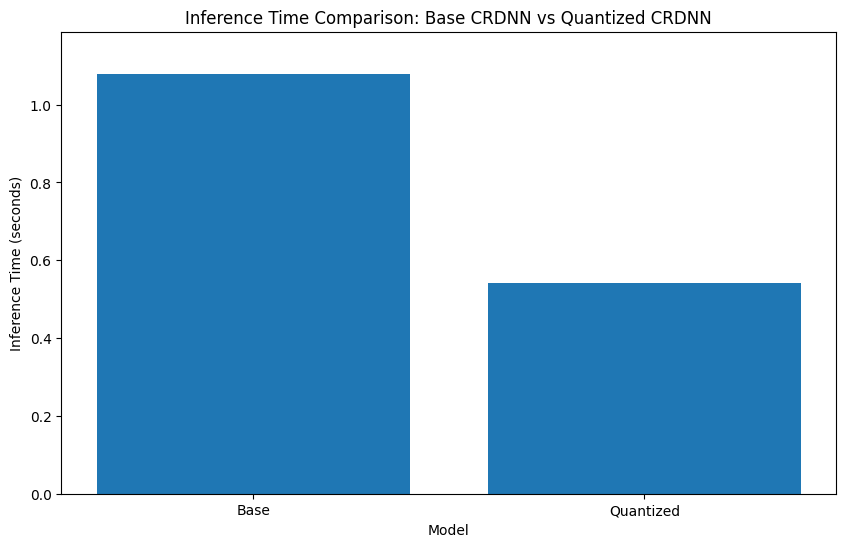

In [23]:
import matplotlib.pyplot as plt

models = ['Base', 'Quantized']
inference_times = [base_model_time, quantized_model_time]

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times)
plt.xlabel('Model')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison: Base CRDNN vs Quantized CRDNN')
plt.ylim(0, max(inference_times) * 1.1)
plt.show()